In [13]:
import numpy as np 
from qiskit import QuantumRegister, ClassicalRegister,QuantumCircuit, transpile, Aer
from qiskit import IBMQ, Aer, assemble
from qiskit.providers.aer import QasmSimulator, noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from Hamming import *
import qiskit
%matplotlib inline
from random import randint
from qiskit import IBMQ
from qiskit.visualization import plot_histogram

#Needed in order to load the ibm-mps simulator for an optimal simulation
#provider = IBMQ.load_account()

In [3]:
# Create a hamming circuit
N = 3
sizeDec=HammingSize(N,'decoder')
sizeEnc=HammingSize(N,'encoder')
circuit = QuantumCircuit(sizeDec,sizeDec)

# Create a input
circuit.h(0)
circuit.cx(0,1)
circuit.x(1)
circuit.cx(0,2)

# Add the encoder to the circuit
circuit.append(HammingEncode(N), range(sizeEnc))

# Add errors
circuit.y(4)

# Add the decoder to the circuit
circuit.append(HammingDecode(N,read=True),range(sizeDec))

# Measure the qubits
circuit.measure(list(range(N)),list(range(N)))

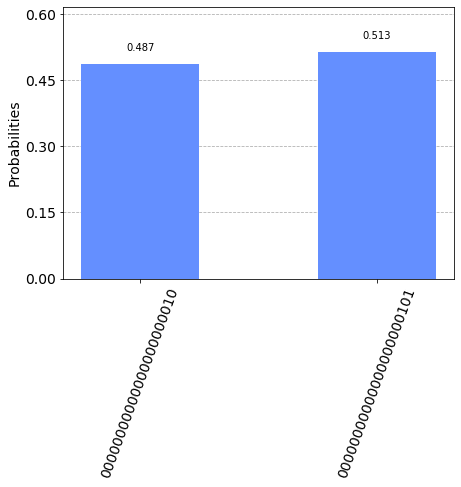

In [3]:
# Simulate the circuit
simulator = Aer.get_backend("qasm_simulator")
result = qiskit.execute(circuit, backend = simulator, shots=1000).result()

from qiskit.tools.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

In [5]:
simulator = Aer.get_backend("qasm_simulator")

In [30]:
p=0.1
n=2
a=np.sqrt(1-p)
b=np.sqrt(p/n)
kraus=[a*np.array([[1,0],[0,1]]),
       b*np.array([[0,1],[1,0]]),
       b*np.array([[1,0],[0,-1]])]

noise.QuantumError(kraus,3,3).to_quantumchannel() #if given the size of the hamming code it doesn't work because it's too big

SuperOp([[0.95+0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
         [0.  +0.j, 0.85+0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
         [0.  +0.j, 0.  +0.j, 0.95+0.j, ..., 0.  +0.j, 0.  +0.j, 0.  +0.j],
         ...,
         [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.95+0.j, 0.  +0.j, 0.  +0.j],
         [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.85+0.j, 0.  +0.j],
         [0.  +0.j, 0.  +0.j, 0.  +0.j, ..., 0.  +0.j, 0.  +0.j, 0.95+0.j]],
        input_dims=(2, 2, 2), output_dims=(2, 2, 2))

In [6]:
def get_noise(p_meas,p_gate):
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = depolarizing_error(p_gate, 1)
    error_gate2 = error_gate1.tensor(error_gate1)

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
    noise_model.add_all_qubit_quantum_error(error_gate1, ["x"]) # single qubit gate error is applied to x gates
    noise_model.add_all_qubit_quantum_error(error_gate2, ["cx"]) # two qubit gate error is applied to cx gates
        
    return noise_model

In [19]:
noise_model = get_noise(0.01,0.01)


channel=noise.kraus_error(kraus).to_quantumchannel()
print(channel.input_dims)


qc0 = QuantumCircuit(3) # initialize circuit with three qubits in the 0 state
qc0.append(channel)
qc0.measure_all() # measure the qubits

# run the circuit with the noise model and extract the counts
qobj = assemble(qc0)
counts = simulator.run(qobj, noise_model=noise_model).result().get_counts()

plot_histogram(counts)

<bound method BaseOperator.input_dims of SuperOp([[ 0.55+0.j,  0.  +0.j,  0.  +0.j,  0.45+0.j],
         [ 0.  +0.j, -0.35+0.j,  0.45+0.j,  0.  +0.j],
         [ 0.  +0.j,  0.45+0.j, -0.35+0.j,  0.  +0.j],
         [ 0.45+0.j,  0.  +0.j,  0.  +0.j,  0.55+0.j]],
        input_dims=(2,), output_dims=(2,))>


CircuitError: 'The amount of qubit arguments 0 does not match the instruction expectation (1).'

In [5]:
# Get coupling map from backend
coupling_map = backend.configuration().coupling_map #zz noise model from real machines

#The following adds custom noise model to the circuit
# Error probabilities
"""prob_1 = 0.001  # 1-qubit gate
prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
error_1 = noise.depolarizing_error(prob_1, 1)
error_2 = noise.depolarizing_error(prob_2, 2)
error_1 = NoiseModel.depolarizing_error(prob_1, 1)
error_2 = NoiseModel.depolarizing_error(prob_2, 2)

# Add errors to noise model
noise_model = noise.NoiseModel()
noise_model = NoiseModel.NoiseModel()
noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(error_2, ['cx'])"""

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
print("\n", basis_gates)
basis_gates = ['cx', 'id', 'rz', 'sx', 'x']
basis_gates = ['cx', 'id', 'u1', 'sx', 'x']
# end of initialization of noise
print(basis_gates)


 ['cx', 'id', 'rz', 'sx', 'x']
['cx', 'id', 'u1', 'sx', 'x']


In [6]:
result_noise = qiskit.execute(circuit, backend = simulator, shots=1000, 
                              #zz coupling_map=coupling_map,
                              # basis_gates=basis_gates,
                              noise_model=noise_model).result()

from qiskit.tools.visualization import plot_histogram
plot_histogram(result_noise.get_counts(circuit))